# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [1]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [2]:
#!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [4]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [6]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-02-25 18:01:44--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.003s  

2025-02-25 18:01:44 (6.20 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-02-25 18:01:45--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text/plain]
Sa

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [5]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [6]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 2, 23, 7, 3, 38, 535961)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [8]:
import os
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

# Create directory if it doesn't exist
os.makedirs("qdrant_file_store", exist_ok=True)

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Try with explicit path and error handling
try:
    vectorstore = Qdrant.from_documents(
        documents,
        embeddings,
        path=os.path.abspath("qdrant_file_store"),
        collection_name="JohnWick"
    )
except Exception as e:
    print(f"Error creating Qdrant vectorstore: {e}")
    # Fallback to in-memory if file storage fails
    print("Falling back to in-memory storage")
    vectorstore = Qdrant.from_documents(
        documents,
        embeddings,
        location=":memory:",
        collection_name="JohnWick"
    )

Error creating Qdrant vectorstore: Storage folder /home/pkang/ai/aibootcamp/AIE5/13_Advanced_Retrieval/qdrant_file_store is already accessed by another instance of Qdrant client. If you require concurrent access, use Qdrant server instead.
Falling back to in-memory storage


## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [9]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [10]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [11]:
from langchain_openai import ChatOpenAI

#chat_model = ChatOpenAI()
chat_model = ChatOpenAI(model="gpt-4o-mini")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [12]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [13]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, people generally liked John Wick. Reviews highlight its stylish action, Keanu Reeves' performance, and the unique elements of the film. Many reviewers consider it one of the best action films and recommend it, particularly to fans of the genre. While there are some mixed opinions, the overall reception is positive, with several reviewers expressing strong enthusiasm for the film and the franchise."

In [14]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n\n- [A Masterpiece & Brilliant Sequel](https://www.imdb.com/review/rw4854296/?ref_=tt_urv)'

In [15]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick," an ex-hit-man named John Wick, portrayed by Keanu Reeves, comes out of retirement to seek vengeance after gangsters kill his dog and steal his car. The dog was a gift from his deceased wife, adding an emotional layer to his quest for revenge. The story focuses on Wick\'s relentless pursuit of those responsible, leading him to confront numerous adversaries in a violent and action-packed narrative. As he battles against the criminal underworld, Wick\'s formidable skills as an assassin are highlighted, and he becomes a target himself, with a bounty placed on his head. The film is known for its stylish and choreographed action sequences, depicting Wick as a legendary figure in the world of assassins.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [16]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [17]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [18]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'People have mixed feelings about the John Wick series. Some reviews are very positive, highlighting the action and the unique plot, like the review that calls the first John Wick "something special" and praises its world-building and action sequences. However, there are also negative reviews, such as one for John Wick 3 that criticizes it for being "mindless" and "plotless." Additionally, a review of John Wick 4 describes it as the weakest installment, emphasizing a lack of meaningful narrative. Overall, while many seem to enjoy the series, there are also significant criticisms from others, indicating a divide in audience reception.'

In [19]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'There are no reviews with a rating of 10 in the provided context.'

In [23]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick," the story revolves around a retired hitman named John Wick, played by Keanu Reeves. After the death of his wife, he lives a quiet life until a group of gangsters break into his home, steal his car, and kill his puppy, which was a final gift from his late wife. This act of violence reignites his old life, and John Wick seeks revenge against those responsible. The film is known for its beautifully choreographed action sequences, emotional depth, and exploration of the hitman underworld, making it a highly regarded action film.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [20]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [21]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [26]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked "John Wick." Reviews highlight it as a highly entertaining action film, with praise for its action sequences, Keanu Reeves\' performance, and its unique style. The movie is described as "the best action film of the year" and is recommended to action buffs and general audiences alike. However, reactions to later installments like "John Wick 3" seem to vary, with some suggesting that the magic was gone in that sequel. Overall, the original film received positive feedback.'

In [27]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. Here are the URLs to those reviews:\n\n1. [Review by ymyuseda](https://www.imdb.com/review/rw4854296/?ref_=tt_urv) - Review Date: 15 May 2019\n'

In [33]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick," the story centers around a former hitman, John Wick (played by Keanu Reeves), who comes out of retirement to seek revenge after gangsters kill his beloved dog and steal his car. The dog was a last gift from his deceased wife, and its loss sends him on a path of vengeance against those responsible. As he embarks on this mission, he faces numerous challenges and encounters various assassins, all of whom are drawn to the substantial bounty placed on his head due to his reputation as a legendary hitman.\n\nIn "John Wick 2," after resolving his past issues with the Russian mafia, John Wick returns home, only to be confronted by mobster Santino D\'Antonio, who demands his assistance in fulfilling a blood oath. When Wick refuses, Santino retaliates by blowing up his house. Wick is then forced to honor the marker by killing Santino\'s sister, which leads to further complications and a $7 million contract placed on his life, attracting a multitude of killers after him. The stor

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [22]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [23]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [31]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, people generally liked John Wick. The reviews indicate that the series has been well received, with many praising the action, Keanu Reeves' performance, and the overall entertainment value. While there are some mixed opinions, especially regarding the later films, most viewers appreciate the franchise's unique style and consistency."

In [32]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n\n- [A Masterpiece & Brilliant Sequel](https://www.imdb.com/review/rw4854296/?ref_=tt_urv)'

In [32]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick," the story follows John Wick, played by Keanu Reeves, a retired hitman who is drawn back into the criminal underworld after a tragic event. The film begins with the recent death of his wife, which leaves him heartbroken. Soon after, a group of Russian mobsters breaks into his home, steals his car, and tragically kills his dog, which was a final gift from his wife. This act of violence ignites Wick\'s thirst for vengeance, leading him to unleash a brutal rampage against those responsible.\n\nAs he seeks retribution, the film showcases his extraordinary skills as an assassin, drawing other criminals into the conflict. The action is characterized by stylish choreography and intense combat sequences, making it a notable entry in the action genre. Throughout the film, Wick\'s motivations are rooted in loss and revenge, which drive him to confront the very organizations he once distanced himself from. Ultimately, "John Wick" is a tale of relentless vengeance in a world filled

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [24]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [26]:
#client = QdrantClient(location=":memory:")
os.makedirs("qdrant_parent_store", exist_ok=True)
client = QdrantClient(path=os.path.abspath("qdrant_parent_store"))

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/tmp/ipykernel_1755566/3298825889.py:10: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [27]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [28]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [29]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [30]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, people have mixed opinions about the "John Wick" series. Some reviews express strong enjoyment and appreciation for the films, highlighting their action and emotional depth, while others criticize specific aspects like the plot and fight scenes. For example, one reviewer described "John Wick 4" as "horrible" and criticized the plot and fight choreography, while another reviewer praised the series as consistently well-received and particularly enjoyed the fourth installment. Overall, it seems that while many people like the series, there are significant criticisms from certain viewers as well.'

In [41]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n\n- [A Masterpiece & Brilliant Sequel](https://www.imdb.com/review/rw4854296/?ref_=tt_urv)'

In [31]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick," a retired assassin named John Wick, played by Keanu Reeves, seeks vengeance after gangsters kill his dog and steal his car. The story revolves around his relentless quest for retribution, forcing him to confront various enemies and assassins due to the immense price placed on his head. The film is characterized by its ultra-violent action sequences and intense shootouts.\n\nIn the sequel, "John Wick: Chapter 2," the narrative picks up shortly after the first film. John is drawn back into the world of assassins when he must pay off an old debt. He embarks on a violent journey across various locations, including Italy and Manhattan, leading to him killing numerous assassins as he helps an associate take over the Assassin\'s Guild. The movie features high-octane chases and fights right from the beginning, maintaining the intense action from the first installment.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [34]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [35]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [45]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, people generally liked John Wick. Many reviews highlight its stylish action sequences, Keanu Reeves' performance, and the film's entertaining and engaging nature. Several reviewers described it as one of the best action films of the year or even the best in a decade, praising its unique and fun take on the genre. While there are some negative opinions, the overall reception appears to be very positive."

In [46]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n\n- [A Masterpiece & Brilliant Sequel](https://www.imdb.com/review/rw4854296/?ref_=tt_urv) \n\nThis review is for "John Wick 3."'

In [36]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick," an ex-hit-man named John Wick, played by Keanu Reeves, comes out of retirement after the tragic death of his beloved wife. The film\'s inciting incident occurs when a group of gangsters, led by an arrogant Russian mob prince, steals his car and kills his dog, which was a final gift from his deceased wife. This act of violence prompts Wick to seek vengeance against those who have wronged him.\n\nAs he embarks on his quest for revenge, Wick unleashes a wave of destruction upon the Russian mobsters who crossed him. The film is filled with intense action sequences and showcases Wick\'s formidable skills as an assassin. It establishes him as a legendary figure in the criminal underworld, known as "the Boogeyman." The story focuses on themes of loss, vengeance, and the consequences of one\'s actions within a violent and stylized world of assassins. Ultimately, Wick\'s journey is propelled by his need for retribution and the brutal path he takes to reclaim his peace.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [48]:
#!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [37]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [38]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [39]:
os.makedirs("qdrant_semantic_store", exist_ok=True)

semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    path=os.path.abspath("qdrant_semantic_store"),  # Use 'path' instead of 'location'
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [40]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [41]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [54]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, people generally liked John Wick. The reviews highlight positive aspects such as exciting action sequences, Keanu Reeves' performance, and the unique style of the films. Many reviewers mention that the franchise has set new standards for action movies and express enthusiasm for the series overall. However, there are some mixed opinions, particularly about the later installments, indicating that while the series has a strong fan base, not everyone feels the same way about every film."

In [55]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n\n- [A Masterpiece & Brilliant Sequel](https://www.imdb.com/review/rw4854296/?ref_=tt_urv)'

In [42]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick," the main character, played by Keanu Reeves, is a retired assassin who seeks vengeance after a group of thugs breaks into his home, beats him, steals his car, and kills his beloved dog. This dog was a final gift from his deceased wife, symbolizing his last connection to her. John Wick\'s quest for revenge leads to a violent confrontation with the Russian mob responsible for these actions, as he unleashes his formidable skills to take on anyone who stands in his way. The film is noted for its stylish action sequences and the intriguing dynamics within a criminal underworld.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

### Knowledge Graph Based Synthetic Generation

In [43]:
import os
from getpass import getpass

os.environ["RAGAS_APP_TOKEN"] = getpass("Please enter your Ragas API key!")### YOUR CODE HERE

#uv add ragas
# uv add nltk
# uv add rapidfuzz

In [44]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /home/pkang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/pkang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [45]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [46]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(documents, testset_size=10)

Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node c280cf7d-ddb2-4d42-97d1-88da1abfdfb2 does not have a summary. Skipping filtering.
Node 97fb62d9-ba50-4a49-aa95-22c7c5a67b57 does not have a summary. Skipping filtering.
Node cfdee6b2-f8d1-4368-aaac-36dc05869363 does not have a summary. Skipping filtering.
Node 0efc0cd6-57ea-4335-b2a0-55df5dbd939e does not have a summary. Skipping filtering.
Node 086e9871-8250-47c0-bac2-a5e7339aff1c does not have a summary. Skipping filtering.
Node 1e92b9ed-1064-4885-836e-a11c25191254 does not have a summary. Skipping filtering.
Node 347f7685-4223-41cd-b5e6-fefe5ac830d3 does not have a summary. Skipping filtering.
Node 0b7ed3c2-f2cc-4c1d-ba96-595820f4ce0d does not have a summary. Skipping filtering.
Node 13b2563d-aadd-4333-802d-68d5ee6470fd does not have a summary. Skipping filtering.
Node 9761b031-0198-4c4e-9aed-c02ed3432fc9 does not have a summary. Skipping filtering.
Node 00d0039c-7f6c-45bc-83c3-2b6f929f09ed does not have a summary. Skipping filtering.
Node 1b7f2973-3733-4cf6-9dd5-d52e07b68ec6 d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/244 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [47]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What is the basic plot of John Wick?,[: 0\nReview: The best way I can describe John...,The basic plot of John Wick involves Keanu Ree...,single_hop_specifc_query_synthesizer
1,Why is John Wick popular among audiences?,[: 2\nReview: With the fourth installment scor...,The fourth installment of John Wick is scoring...,single_hop_specifc_query_synthesizer
2,Who is Chad Stahelski and what makes his direc...,[: 3\nReview: John wick has a very simple reve...,Chad Stahelski is a director known for his exp...,single_hop_specifc_query_synthesizer
3,What them Russian mobsters do in John Wick?,[: 4\nReview: Though he no longer has a taste ...,"In John Wick, a group of Russian mobsters vict...",single_hop_specifc_query_synthesizer
4,What motivates John Wick to come out of retire...,[: 5\nReview: Ultra-violent first entry with l...,"In the original John Wick (2014), the ex-hit-m...",single_hop_specifc_query_synthesizer
5,What John Wick: Chapter 3 - Parabellum about a...,[<1-hop>\n\n: 24\nReview: John Wick: Chapter 3...,John Wick: Chapter 3 - Parabellum is about the...,multi_hop_specific_query_synthesizer
6,How does Parabellum expand the world of John W...,[<1-hop>\n\n: 0\nReview: It is 5 years since t...,Parabellum expands the world of John Wick by i...,multi_hop_specific_query_synthesizer
7,How did the film 'Parabellum' contribute to th...,[<1-hop>\n\n: 4\nReview: I went to the cinema ...,The film 'Parabellum' contributed to the perce...,multi_hop_specific_query_synthesizer
8,Is 'John Wick: Chapter 4' considered the best ...,[<1-hop>\n\n: 20\nReview: In a world where mov...,The reviews for 'John Wick: Chapter 4' are mix...,multi_hop_specific_query_synthesizer
9,How does Ian McShane's character influence Joh...,[<1-hop>\n\n: 20\nReview: John Wick is somethi...,"Ian McShane plays Winston, the owner of the Co...",multi_hop_specific_query_synthesizer


### LangChain RAG  Pipeline

#### Naive Retrieval

In [48]:
for test_row in dataset:
  response = naive_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [70]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [71]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [74]:
from ragas.metrics import LLMContextRecall, ContextEntityRecall, NoiseSensitivity, ContextPrecision
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), ContextEntityRecall(), NoiseSensitivity(), ContextPrecision()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[2]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[22]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[26]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[34]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[38]: TimeoutError()


{'context_recall': 0.8300, 'context_entity_recall': 0.7217, 'noise_sensitivity_relevant': 0.3825, 'context_precision': 0.7558}

#### bm25 retrieval

In [75]:
for test_row in dataset:
  response = bm25_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [76]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [77]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [78]:
from ragas.metrics import LLMContextRecall, ContextEntityRecall, NoiseSensitivity, ContextPrecision
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), ContextEntityRecall(), NoiseSensitivity(), ContextPrecision()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

{'context_recall': 0.3000, 'context_entity_recall': 0.4983, 'noise_sensitivity_relevant': 0.1823, 'context_precision': 0.1417}

#### contextual compression Retrieval


In [79]:
for test_row in dataset:
  response = contextual_compression_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [80]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [81]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [82]:
from ragas.metrics import LLMContextRecall, ContextEntityRecall, NoiseSensitivity, ContextPrecision
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), ContextEntityRecall(), NoiseSensitivity(), ContextPrecision()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

{'context_recall': 0.8300, 'context_entity_recall': 0.6517, 'noise_sensitivity_relevant': 0.3025, 'context_precision': 0.8083}

#### Multi-Query Retrieval

In [83]:
for test_row in dataset:
  response = multi_query_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [84]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [85]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [86]:
from ragas.metrics import LLMContextRecall, ContextEntityRecall, NoiseSensitivity, ContextPrecision
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), ContextEntityRecall(), NoiseSensitivity(), ContextPrecision()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[2]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[18]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[22]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[26]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[30]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[34]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[38]: TimeoutError()


{'context_recall': 0.8500, 'context_entity_recall': 0.6229, 'noise_sensitivity_relevant': 0.4537, 'context_precision': 0.7140}

#### Parent Document Retrieval

In [87]:
for test_row in dataset:
  response = parent_document_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [88]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [89]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [90]:
from ragas.metrics import LLMContextRecall, ContextEntityRecall, NoiseSensitivity, ContextPrecision
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), ContextEntityRecall(), NoiseSensitivity(), ContextPrecision()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

{'context_recall': 0.4800, 'context_entity_recall': 0.5150, 'noise_sensitivity_relevant': 0.2849, 'context_precision': 0.7000}

#### Ensemble Retrieval

In [91]:
for test_row in dataset:
  response = ensemble_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [92]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [93]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [94]:
from ragas.metrics import LLMContextRecall, ContextEntityRecall, NoiseSensitivity, ContextPrecision
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), ContextEntityRecall(), NoiseSensitivity(), ContextPrecision()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[2]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[5]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[6]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[10]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[14]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[18]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[22]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[26]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[30]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[34]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[38]: TimeoutError()


{'context_recall': 0.9667, 'context_entity_recall': 0.7333, 'noise_sensitivity_relevant': nan, 'context_precision': 0.6974}

#### Semantic Chunking Retrieval

In [49]:
for test_row in dataset:
  response = semantic_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [50]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [51]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [52]:
from ragas.metrics import LLMContextRecall, ContextEntityRecall, NoiseSensitivity, ContextPrecision
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), ContextEntityRecall(), NoiseSensitivity(), ContextPrecision()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Exception raised in Job[10]: TimeoutError()
Exception raised in Job[26]: TimeoutError()


{'context_recall': 0.8667, 'context_entity_recall': 0.7125, 'noise_sensitivity_relevant': 0.2533, 'context_precision': 0.6427}

### RAGAS Evaluation Results

Evaluation Results Summary
| Retrieval Method | Context Recall | Context Entity Recall | Noise Sensitivity | Context Precision |
|------------------|----------------|----------------------|-------------------|------------------|
| Naive | 0.8300 | 0.7217 | 0.3825 | 0.7558 |
| BM25 | 0.3000 | 0.4983 | 0.1823 | 0.1417 |
| Contextual Compression | 0.8300 | 0.6517 | 0.3025 | 0.8083 |
| Multi-Query | 0.8500 | 0.6229 | 0.4537 | 0.7140 |
| Parent Document | 0.4800 | 0.5150 | 0.2849 | 0.7000 |
| Ensemble | 0.9667 | 0.7333 | N/A | 0.6974 |
| Semantic Chunking| 0.8667 | 0.7125 | 0.2533 | 0.6427 |

In [ ]:
# uv add matplotlib

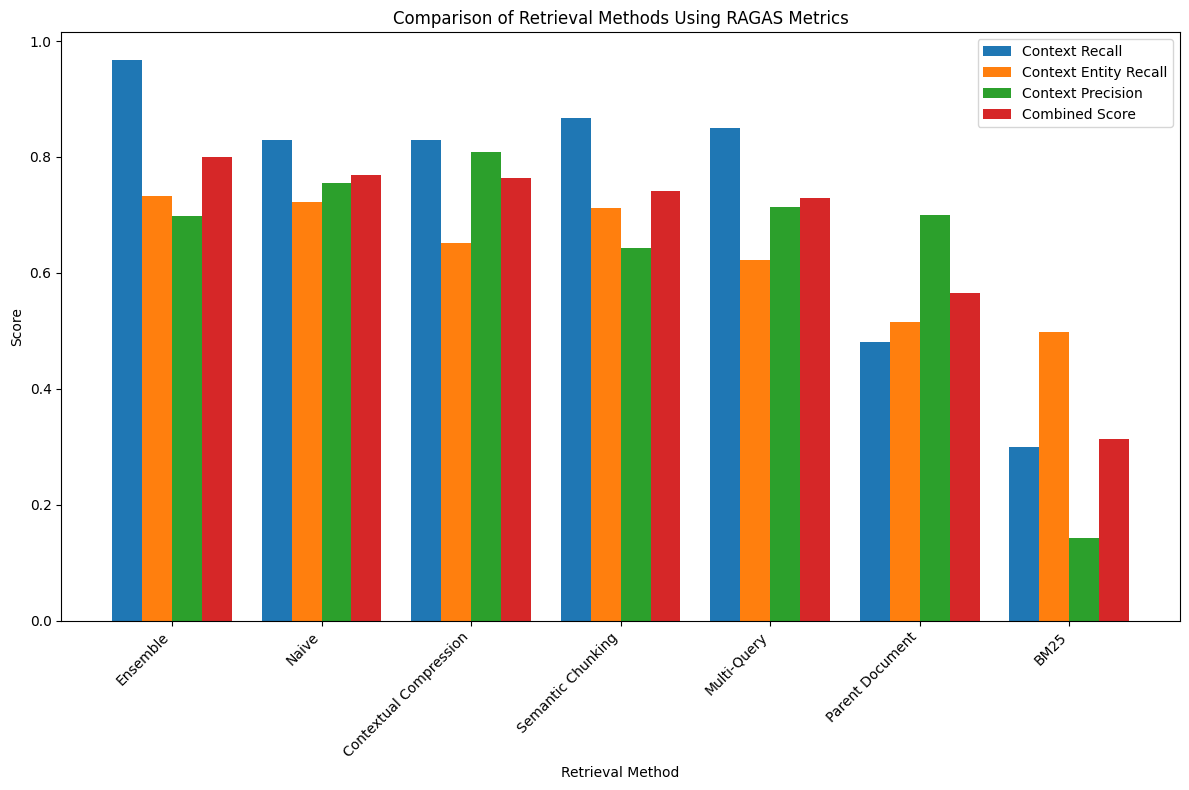

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a DataFrame with the results
data = {
    'Retrieval Method': ['Naive', 'BM25', 'Contextual Compression', 'Multi-Query', 
                         'Parent Document', 'Ensemble', 'Semantic Chunking'],
    'Context Recall': [0.8300, 0.3000, 0.8300, 0.8500, 0.4800, 0.9667, 0.8667],
    'Context Entity Recall': [0.7217, 0.4983, 0.6517, 0.6229, 0.5150, 0.7333, 0.7125],
    'Noise Sensitivity': [0.3825, 0.1823, 0.3025, 0.4537, 0.2849, 0.0, 0.2533],  # Using 0 for N/A
    'Context Precision': [0.7558, 0.1417, 0.8083, 0.7140, 0.7000, 0.6974, 0.6427]
}

df = pd.DataFrame(data)

# Calculate a combined score (average of all metrics)
df['Combined Score'] = df[['Context Recall', 'Context Entity Recall', 'Context Precision']].mean(axis=1)

# Sort by combined score for the chart
df_sorted = df.sort_values('Combined Score', ascending=False)

# Create a bar chart
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(df_sorted['Retrieval Method']))
width = 0.2

# Plot each metric
ax.bar(x - width*1.5, df_sorted['Context Recall'], width, label='Context Recall')
ax.bar(x - width/2, df_sorted['Context Entity Recall'], width, label='Context Entity Recall')
ax.bar(x + width/2, df_sorted['Context Precision'], width, label='Context Precision')
ax.bar(x + width*1.5, df_sorted['Combined Score'], width, label='Combined Score')

# Add labels and title
ax.set_xlabel('Retrieval Method')
ax.set_ylabel('Score')
ax.set_title('Comparison of Retrieval Methods Using RAGAS Metrics')
ax.set_xticks(x)
ax.set_xticklabels(df_sorted['Retrieval Method'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

## Key Findings and Conclusions on retriever performance

1. Best Overall Performance: The Ensemble Retriever demonstrates the highest overall performance with exceptional context recall (0.9667) and strong entity recall (0.7333). This suggests that combining multiple retrieval strategies provides the most comprehensive results.

2. Best Precision: The Contextual Compression Retriever (using Cohere's reranker) achieves the highest context precision (0.8083), indicating it's most effective at retrieving highly relevant documents while minimizing irrelevant information.  

3. Worst Performance: The BM25 Retriever significantly underperforms across all metrics, particularly in context precision (0.1417) and recall (0.3000). This suggests that keyword-based retrieval alone is insufficient for complex queries about movie reviews.

4. Balanced Performance: The Naive Retriever shows surprisingly strong and balanced performance across all metrics, making it a good baseline option when computational resources are limited.

5. Specialized Strengths:
    - Multi-Query Retriever excels in noise sensitivity (0.4537), suggesting it's most robust to variations in query formulation.
    - Semantic Chunking Retriever performs well on context recall (0.8667) and entity recall (0.7125), indicating it effectively captures semantic relationships.

6. Efficiency vs. Effectiveness Tradeoff: While the Ensemble Retriever performs best, it also experienced timeout issues, suggesting higher computational demands. The Contextual Compression Retriever offers an excellent balance of high performance with fewer computational issues.

#### Recommendations

1. For Maximum Accuracy: Use the Ensemble Retriever when comprehensive information retrieval is critical and computational resources are available.

2. For Balanced Performance: The Contextual Compression Retriever offers the best balance of precision and recall with reasonable computational demands.

3. For Resource-Constrained Environments: The Naive Retriever provides surprisingly good results with minimal complexity.

4. Avoid: The BM25 Retriever alone is not recommended for this type of content unless specifically needed for keyword-exact matching.

5. For Production Systems: Consider implementing a tiered approach - start with the Naive or Contextual Compression retriever for most queries, and fall back to the Ensemble retriever for complex or high-importance queries.

This analysis demonstrates that the choice of retrieval method significantly impacts RAG system performance, with modern neural approaches substantially outperforming traditional keyword-based methods for this particular dataset and task.

### LangSmith Dataset

In [55]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

In [56]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

In [57]:
from langsmith import Client

client = Client()

dataset_name = "JohnWick LangSmith Dataset!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="JohnWick LangSmith Dataset!"
)

In [58]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## LangSmith Evaluation Set-up

In [59]:
eval_llm = ChatOpenAI(model="gpt-4o")

In [60]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

coherence_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "coherence": {
                "Is the response coherent with the retrieved data or the query?"  
                "Is the response easy to read and logically structured and well-written?"            
            }          
        },
        "llm" : eval_llm
    }
)

### LangSmith Naive Retrieval Evaluation

In [62]:
naive_results = evaluate(
    naive_retrieval_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        coherence_evaluator
    ],
    metadata={"revision_id": "naive_retrieval_chain"},
)

View the evaluation results for experiment: 'excellent-house-11' at:
https://smith.langchain.com/o/b2bbbf41-ce3b-46fa-8cc0-7de9bb768aa9/datasets/6358e678-d29a-445d-a5e4-feefef89eb02/compare?selectedSessions=4f1b0b8c-fb53-4da8-acd1-19c75f42a577




0it [00:00, ?it/s]

Error running evaluator <DynamicRunEvaluator evaluate> on run 575ab0d5-c4d0-4446-8087-7ad400a3f5fa: ValueError('Evaluator verbose=False prompt=PromptTemplate(input_variables=[\'answer\', \'query\', \'result\'], input_types={}, partial_variables={}, template="You are a teacher grading a quiz.\\nYou are given a question, the student\'s answer, and the true answer, and are asked to score the student answer as either CORRECT or INCORRECT.\\n\\nExample Format:\\nQUESTION: question here\\nSTUDENT ANSWER: student\'s answer here\\nTRUE ANSWER: true answer here\\nGRADE: CORRECT or INCORRECT here\\n\\nGrade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer. It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! \\n\\nQUESTION: {query}\\nSTUDENT ANSWER: {result}\\nTRUE ANSWER: {answer}\\nGRADE:") llm=ChatOpenAI(

,inputs.question,outputs.response,outputs.context,error,reference.answer,feedback.wrapper,execution_time,example_id,id
0,How does Ian McShane's character influence Joh...,"content=""Ian McShane's character plays a signi...","[page_content=': 9\nReview: At first glance, J...",None,"Ian McShane plays Winston, the owner of the Co...",None,1.837578,26fe8b70-0d0d-46e4-bdc4-572214c82dcc,575ab0d5-c4d0-4446-8087-7ad400a3f5fa
1,Is 'John Wick: Chapter 4' considered the best ...,"content='According to the reviews, ""John Wick:...",[page_content=': 20\nReview: In a world where ...,None,The reviews for 'John Wick: Chapter 4' are mix...,None,1.184345,0e3f986b-1a80-413e-bce8-8a6c10e3105a,67d662b9-c5e8-442e-9f98-240276e566df
2,How did the film 'Parabellum' contribute to th...,"content=""I don't have specific information abo...",[page_content=': 8\nReview: In this 2nd instal...,None,The film 'Parabellum' contributed to the perce...,None,1.836779,5f10c1bb-450d-4277-a1c1-ed8013c937a0,14c98fab-43de-4d87-bb02-6a9b86ce2c5a
3,How does Parabellum expand the world of John W...,"content='""John Wick: Chapter 3 - Parabellum"" e...",[page_content=': 19\nReview: John Wick: Chapte...,None,Parabellum expands the world of John Wick by i...,None,3.593456,d6bb98ee-f4a8-477d-8590-581710ae4bba,218011ff-0454-4b99-b45c-630400a22a14
4,What John Wick: Chapter 3 - Parabellum about a...,"content='""John Wick: Chapter 3 - Parabellum"" i...",[page_content=': 24\nReview: John Wick: Chapte...,None,John Wick: Chapter 3 - Parabellum is about the...,None,1.774633,78e03c53-c06e-496c-982a-c594ef6c4c16,79279be4-a8fa-4cc7-ad4e-a5f3472ecaed
5,What motivates John Wick to come out of retire...,content='John Wick comes out of retirement in ...,[page_content=': 5\nReview: Ultra-violent firs...,None,"In the original John Wick (2014), the ex-hit-m...",None,1.179548,ea1ded1c-f812-4bb0-ba2e-f576198c011d,8d7f18ac-102d-4fe0-81c3-74ad1fdf901e
6,What them Russian mobsters do in John Wick?,content='The provided context does not specifi...,[page_content=': 22\nReview: Lets contemplate ...,None,"In John Wick, a group of Russian mobsters vict...",None,0.992287,5cfb1393-c05d-48e9-b7b6-3e606ca8a98a,d5046214-5771-49f5-84d4-95d5d8db2ef0
7,Who is Chad Stahelski and what makes his direc...,content='Chad Stahelski is a director and form...,[page_content=': 3\nReview: John wick has a ve...,None,Chad Stahelski is a director known for his exp...,None,3.233980,8a824ea6-0077-4f19-9c44-f5f35d45c026,3555f97f-ddca-41ba-9164-f380236a7664
8,Why is John Wick popular among audiences?,"content=""John Wick is popular among audiences ...",[page_content=': 16\nReview: John Wick 3 is wi...,None,The fourth installment of John Wick is scoring...,None,2.416881,55ac82ee-4249-4832-afd5-a0db3d2f8acb,de1b4062-9d8f-4bbe-aca6-861fa82519af
9,What is the basic plot of John Wick?,"content='The basic plot of ""John Wick"" revolve...",[page_content=': 5\nReview: The first John Wic...,None,The basic plot of John Wick involves Keanu Ree...,None,1.325190,5826844b-91c9-4d0f-a78b-6ae607fd584f,c28978ef-ef46-43ce-bd28-76e063bf7e8d


### LangSmith BM25 Retrieval Evaluation

In [81]:
bm25_results = evaluate(
    bm25_retrieval_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        coherence_evaluator
    ],
    metadata={"revision_id": "bm25_retrieval_chain"},
)

View the evaluation results for experiment: 'definite-hill-6' at:
https://smith.langchain.com/o/b2bbbf41-ce3b-46fa-8cc0-7de9bb768aa9/datasets/6358e678-d29a-445d-a5e4-feefef89eb02/compare?selectedSessions=db167432-97e4-4257-9d6c-74002345cb6f




0it [00:00, ?it/s]

Error running evaluator <DynamicRunEvaluator evaluate> on run a7d431ec-0836-4228-95b5-950d287cfa98: ValueError('Evaluator verbose=False prompt=PromptTemplate(input_variables=[\'answer\', \'query\', \'result\'], input_types={}, partial_variables={}, template="You are a teacher grading a quiz.\\nYou are given a question, the student\'s answer, and the true answer, and are asked to score the student answer as either CORRECT or INCORRECT.\\n\\nExample Format:\\nQUESTION: question here\\nSTUDENT ANSWER: student\'s answer here\\nTRUE ANSWER: true answer here\\nGRADE: CORRECT or INCORRECT here\\n\\nGrade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer. It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! \\n\\nQUESTION: {query}\\nSTUDENT ANSWER: {result}\\nTRUE ANSWER: {answer}\\nGRADE:") llm=ChatOpenAI(

### LangSmith Contextual Compression Retrieval Evaluation

In [100]:
contextual_compression_results = evaluate(
    contextual_compression_retrieval_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        coherence_evaluator
    ],
    metadata={"revision_id": "contextual_compression_retrieval_chain"},
)

View the evaluation results for experiment: 'extraneous-camp-83' at:
https://smith.langchain.com/o/b2bbbf41-ce3b-46fa-8cc0-7de9bb768aa9/datasets/6358e678-d29a-445d-a5e4-feefef89eb02/compare?selectedSessions=e8f6f077-336a-4ba5-b16f-eab21d52a2c9




0it [00:00, ?it/s]

Error running evaluator <DynamicRunEvaluator evaluate> on run 29acbbb7-9e26-4af3-bb64-2b665bb803bf: ValueError('Evaluator verbose=False prompt=PromptTemplate(input_variables=[\'answer\', \'query\', \'result\'], input_types={}, partial_variables={}, template="You are a teacher grading a quiz.\\nYou are given a question, the student\'s answer, and the true answer, and are asked to score the student answer as either CORRECT or INCORRECT.\\n\\nExample Format:\\nQUESTION: question here\\nSTUDENT ANSWER: student\'s answer here\\nTRUE ANSWER: true answer here\\nGRADE: CORRECT or INCORRECT here\\n\\nGrade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer. It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! \\n\\nQUESTION: {query}\\nSTUDENT ANSWER: {result}\\nTRUE ANSWER: {answer}\\nGRADE:") llm=ChatOpenAI(

### LangSmith Multi-Query Retrieval Evaluation

In [101]:
multi_query_results = evaluate(
    multi_query_retrieval_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        coherence_evaluator
    ],
    metadata={"revision_id": "multi_query_retrieval_chain"},
)

View the evaluation results for experiment: 'only-heart-44' at:
https://smith.langchain.com/o/b2bbbf41-ce3b-46fa-8cc0-7de9bb768aa9/datasets/6358e678-d29a-445d-a5e4-feefef89eb02/compare?selectedSessions=4e63032e-f9b2-4f13-a857-563291c51b91




0it [00:00, ?it/s]

Error running evaluator <DynamicRunEvaluator evaluate> on run 86ff135a-a849-4881-be54-2537cb5c23fe: ValueError('Evaluator verbose=False prompt=PromptTemplate(input_variables=[\'answer\', \'query\', \'result\'], input_types={}, partial_variables={}, template="You are a teacher grading a quiz.\\nYou are given a question, the student\'s answer, and the true answer, and are asked to score the student answer as either CORRECT or INCORRECT.\\n\\nExample Format:\\nQUESTION: question here\\nSTUDENT ANSWER: student\'s answer here\\nTRUE ANSWER: true answer here\\nGRADE: CORRECT or INCORRECT here\\n\\nGrade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer. It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! \\n\\nQUESTION: {query}\\nSTUDENT ANSWER: {result}\\nTRUE ANSWER: {answer}\\nGRADE:") llm=ChatOpenAI(

### Langsmith Parent Document Retrieval Evaluation

In [105]:
parent_document_results = evaluate(
    parent_document_retrieval_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        coherence_evaluator
    ],
    metadata={"revision_id": "parent_document_retrieval_chain"},
)

View the evaluation results for experiment: 'scholarly-history-55' at:
https://smith.langchain.com/o/b2bbbf41-ce3b-46fa-8cc0-7de9bb768aa9/datasets/6358e678-d29a-445d-a5e4-feefef89eb02/compare?selectedSessions=4132138a-2710-4eb3-99bb-4c0b54f146bb




0it [00:00, ?it/s]

Error running evaluator <DynamicRunEvaluator evaluate> on run 8ba25bf4-a07d-4dd7-b4db-e1b7dd07b354: ValueError('Evaluator verbose=False prompt=PromptTemplate(input_variables=[\'answer\', \'query\', \'result\'], input_types={}, partial_variables={}, template="You are a teacher grading a quiz.\\nYou are given a question, the student\'s answer, and the true answer, and are asked to score the student answer as either CORRECT or INCORRECT.\\n\\nExample Format:\\nQUESTION: question here\\nSTUDENT ANSWER: student\'s answer here\\nTRUE ANSWER: true answer here\\nGRADE: CORRECT or INCORRECT here\\n\\nGrade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer. It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! \\n\\nQUESTION: {query}\\nSTUDENT ANSWER: {result}\\nTRUE ANSWER: {answer}\\nGRADE:") llm=ChatOpenAI(

### LangSmith Ensemble Retrieval Evaluation

In [106]:
ensemble_results = evaluate(
    ensemble_retrieval_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        coherence_evaluator
    ],
    metadata={"revision_id": "ensemble_retrieval_chain"},
)

View the evaluation results for experiment: 'ordinary-pain-15' at:
https://smith.langchain.com/o/b2bbbf41-ce3b-46fa-8cc0-7de9bb768aa9/datasets/6358e678-d29a-445d-a5e4-feefef89eb02/compare?selectedSessions=095b42e8-b3a5-4578-8219-5dbbf7fe8dd1




0it [00:00, ?it/s]

Error running evaluator <DynamicRunEvaluator evaluate> on run 07ab09d0-07a2-4a77-b090-e6f21a00228b: ValueError('Evaluator verbose=False prompt=PromptTemplate(input_variables=[\'answer\', \'query\', \'result\'], input_types={}, partial_variables={}, template="You are a teacher grading a quiz.\\nYou are given a question, the student\'s answer, and the true answer, and are asked to score the student answer as either CORRECT or INCORRECT.\\n\\nExample Format:\\nQUESTION: question here\\nSTUDENT ANSWER: student\'s answer here\\nTRUE ANSWER: true answer here\\nGRADE: CORRECT or INCORRECT here\\n\\nGrade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer. It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! \\n\\nQUESTION: {query}\\nSTUDENT ANSWER: {result}\\nTRUE ANSWER: {answer}\\nGRADE:") llm=ChatOpenAI(

### LangSmith Semantic Retrieval Evaluation

In [107]:
semantic_results = evaluate(
    semantic_retrieval_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        coherence_evaluator
    ],
    metadata={"revision_id": "semantic_retrieval_chain"},
)

View the evaluation results for experiment: 'proper-knowledge-23' at:
https://smith.langchain.com/o/b2bbbf41-ce3b-46fa-8cc0-7de9bb768aa9/datasets/6358e678-d29a-445d-a5e4-feefef89eb02/compare?selectedSessions=a1a5959d-e70b-468a-92cc-6386d7939746




0it [00:00, ?it/s]

Error running evaluator <DynamicRunEvaluator evaluate> on run 2d09d8b9-a8ad-4ce7-8730-8f7b1dedccb0: ValueError('Evaluator verbose=False prompt=PromptTemplate(input_variables=[\'answer\', \'query\', \'result\'], input_types={}, partial_variables={}, template="You are a teacher grading a quiz.\\nYou are given a question, the student\'s answer, and the true answer, and are asked to score the student answer as either CORRECT or INCORRECT.\\n\\nExample Format:\\nQUESTION: question here\\nSTUDENT ANSWER: student\'s answer here\\nTRUE ANSWER: true answer here\\nGRADE: CORRECT or INCORRECT here\\n\\nGrade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer. It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! \\n\\nQUESTION: {query}\\nSTUDENT ANSWER: {result}\\nTRUE ANSWER: {answer}\\nGRADE:") llm=ChatOpenAI(

In [92]:
#bm25_resp = client.read_project(project_name=bm25_results.experiment_name, include_stats=True)
#bm25_metrics = extract_metrics_from_experiment(bm25_resp.json(indent=2))

### LangSmith Retrieval Evaluation for Latency and Token Usage

In [95]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langsmith import Client

In [96]:
# Cell 3: Define the function to extract metrics
def extract_metrics_from_experiment(experiment_json):
    """
    Extract token usage and latency metrics from a LangSmith experiment JSON response
    
    Args:
        experiment_json: Either a dictionary or a JSON string
    """
    # Convert to dictionary if it's a string
    if isinstance(experiment_json, str):
        try:
            experiment_json = json.loads(experiment_json)
        except json.JSONDecodeError:
            print("Error: Invalid JSON string")
            return {}
    
    metrics = {
        # Token usage
        "total_tokens": experiment_json.get("total_tokens", 0),
        "prompt_tokens": experiment_json.get("prompt_tokens", 0),
        "completion_tokens": experiment_json.get("completion_tokens", 0),
        
        # Latency
        "latency_p50": experiment_json.get("latency_p50", 0),  # Median latency
        "latency_p99": experiment_json.get("latency_p99", 0),  # 99th percentile latency
        
        # Cost
        "total_cost": experiment_json.get("total_cost", 0),
        "prompt_cost": experiment_json.get("prompt_cost", 0),
        "completion_cost": experiment_json.get("completion_cost", 0),
        
        # Run information
        "run_count": experiment_json.get("run_count", 0),
        "retriever_type": experiment_json.get("extra", {}).get("metadata", {}).get("revision_id", "unknown")
    }
    
    return metrics

In [110]:
# Cell 4: Compare experiments using the result objects
# This assumes you have already run the experiments and have the result objects

# List of experiment result objects
experiment_results = [
    naive_results,     # Replace with your actual result object names
    bm25_results,
    contextual_compression_results,
    multi_query_results,
    parent_document_results,
    ensemble_results,
    semantic_results
]

# List of experiment names (for better labeling)
retriever_names = [
    "Naive Retriever",
    "BM25 Retriever",
    "Contextual Compression Retriever",
    "Multi-Query Retriever",
    "Parent Document Retriever",
    "Ensemble Retriever",
    "Semantic Retriever"
]

# Collect metrics for all experiments
all_metrics = []

for i, result in enumerate(experiment_results):
    try:
        # Get the experiment data from LangSmith
        exp_resp = client.read_project(project_name=result.experiment_name, include_stats=True)
        
        # Extract metrics
        metrics = extract_metrics_from_experiment(exp_resp.json())
        
        # Add experiment name and retriever name
        metrics["experiment_name"] = result.experiment_name
        metrics["retriever_name"] = retriever_names[i]
        
        all_metrics.append(metrics)
        print(f"Successfully processed experiment: {result.experiment_name} ({retriever_names[i]})")
        
    except Exception as e:
        print(f"Error processing experiment {retriever_names[i]}: {e}")

# Create DataFrame from all metrics
comparison_df = pd.DataFrame(all_metrics)

# Calculate tokens per run
comparison_df['tokens_per_run'] = comparison_df['total_tokens'] / comparison_df['run_count'].apply(lambda x: max(x, 1))

# Display the comparison
print("\nComparison of Retrieval Methods:")
print(comparison_df[['retriever_name', 'total_tokens', 'latency_p50', 'total_cost', 'run_count', 'tokens_per_run']])

Successfully processed experiment: proper-pleasure-59 (Naive Retriever)
Successfully processed experiment: definite-hill-6 (BM25 Retriever)
Successfully processed experiment: extraneous-camp-83 (Contextual Compression Retriever)
Successfully processed experiment: only-heart-44 (Multi-Query Retriever)
Successfully processed experiment: scholarly-history-55 (Parent Document Retriever)
Successfully processed experiment: ordinary-pain-15 (Ensemble Retriever)
Successfully processed experiment: proper-knowledge-23 (Semantic Retriever)

Comparison of Retrieval Methods:
                     retriever_name  total_tokens  latency_p50  total_cost  \
0                   Naive Retriever         37390       3.6495    0.006513   
1                    BM25 Retriever         14322       1.7995    0.002869   
2  Contextual Compression Retriever         12620       3.3895    0.002637   
3             Multi-Query Retriever         51678       4.5595    0.008943   
4         Parent Document Retriever      

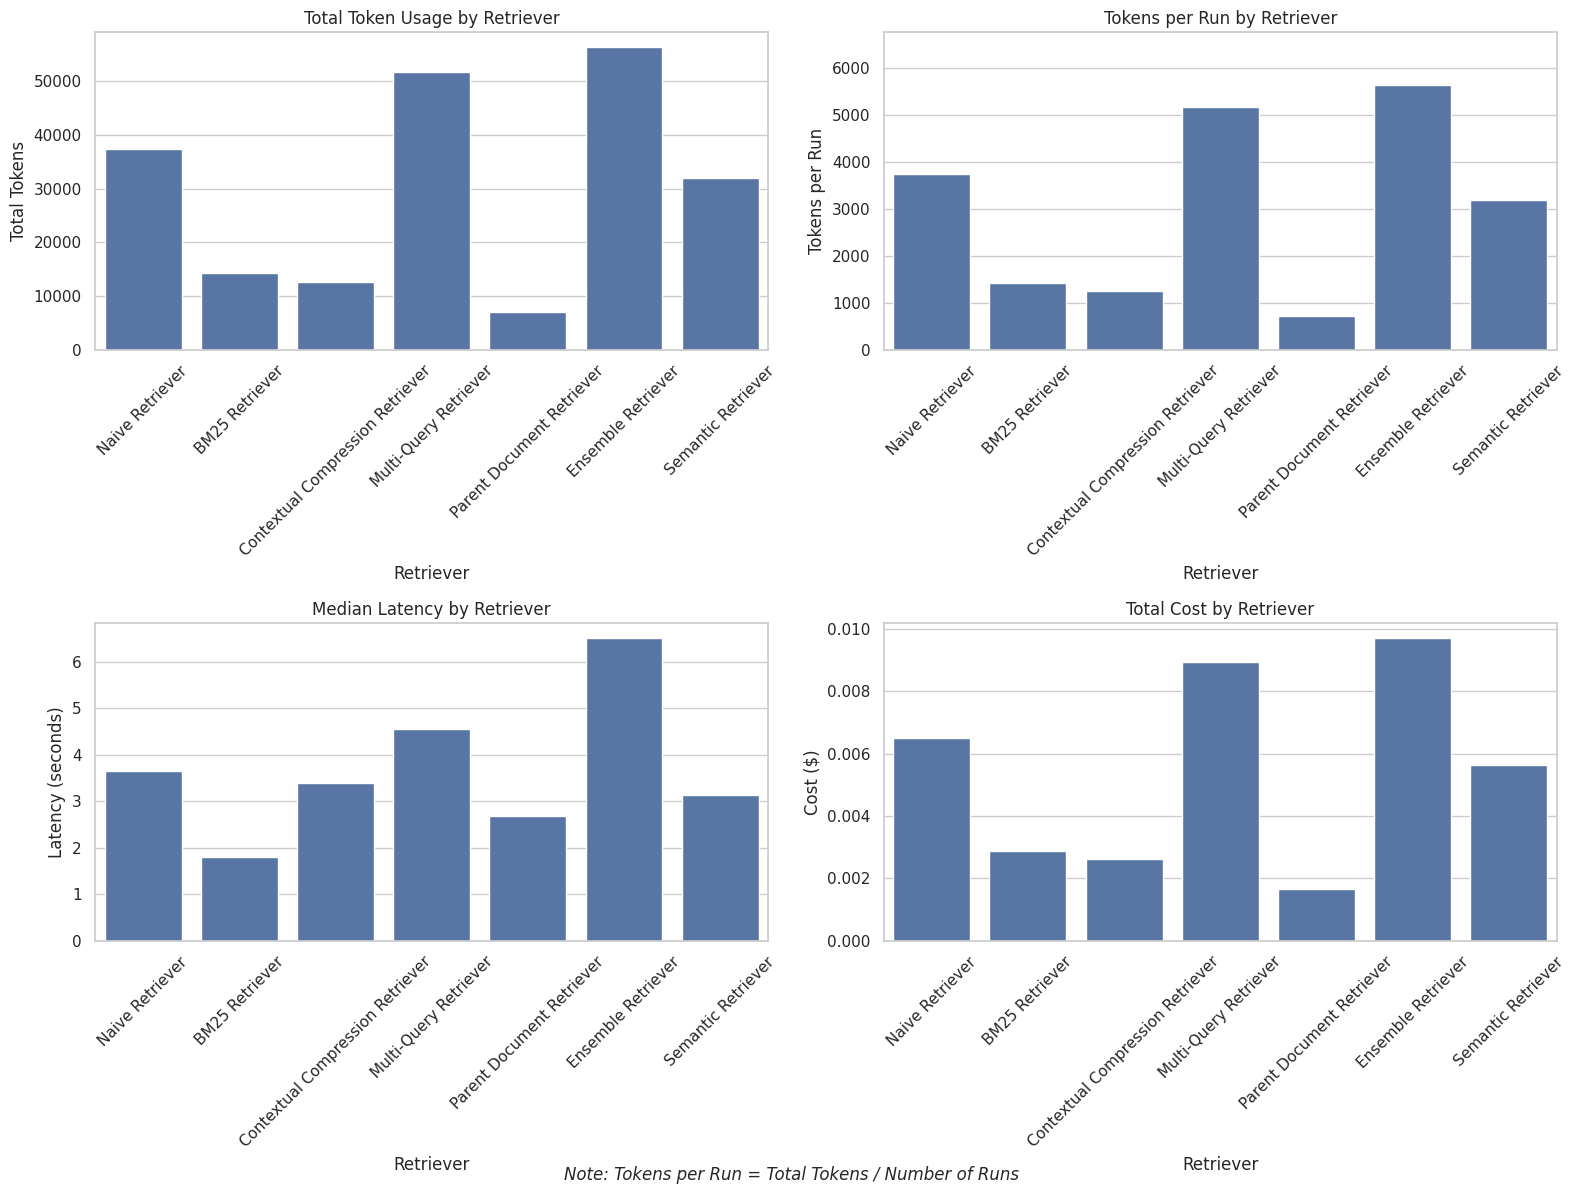


Detailed Comparison Table:
                     retriever_name  total_tokens  tokens_per_run  \
0                   Naive Retriever         37390          3739.0   
1                    BM25 Retriever         14322          1432.2   
2  Contextual Compression Retriever         12620          1262.0   
3             Multi-Query Retriever         51678          5167.8   
4         Parent Document Retriever          7106           710.6   
5                Ensemble Retriever         56330          5633.0   
6                Semantic Retriever         31992          3199.2   

   latency_p50  total_cost  tokens_per_second  run_count  
0        3.650    0.006513            1024.38         10  
1        1.800    0.002869             795.67         10  
2        3.390    0.002637             372.27         10  
3        4.560    0.008943            1133.29         10  
4        2.678    0.001648             265.35         10  
5        6.500    0.009691             866.62         10  
6     

In [111]:
# Cell 5: Visualize the comparison (Fixed version)
if not comparison_df.empty:
    # Set the style
    sns.set(style="whitegrid")
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot token usage (total tokens)
    sns.barplot(x='retriever_name', y='total_tokens', data=comparison_df, ax=axes[0, 0])
    axes[0, 0].set_title('Total Token Usage by Retriever')
    axes[0, 0].set_xlabel('Retriever')
    axes[0, 0].set_ylabel('Total Tokens')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot tokens per run (make sure the scale is different)
    sns.barplot(x='retriever_name', y='tokens_per_run', data=comparison_df, ax=axes[0, 1])
    axes[0, 1].set_title('Tokens per Run by Retriever')
    axes[0, 1].set_xlabel('Retriever')
    axes[0, 1].set_ylabel('Tokens per Run')
    axes[0, 1].tick_params(axis='x', rotation=45)
    # Force y-axis to start at 0 and have a different scale than the total tokens plot
    max_tokens_per_run = comparison_df['tokens_per_run'].max()
    axes[0, 1].set_ylim(0, max_tokens_per_run * 1.2)  # Add 20% padding
    
    # Plot latency
    sns.barplot(x='retriever_name', y='latency_p50', data=comparison_df, ax=axes[1, 0])
    axes[1, 0].set_title('Median Latency by Retriever')
    axes[1, 0].set_xlabel('Retriever')
    axes[1, 0].set_ylabel('Latency (seconds)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Plot cost
    sns.barplot(x='retriever_name', y='total_cost', data=comparison_df, ax=axes[1, 1])
    axes[1, 1].set_title('Total Cost by Retriever')
    axes[1, 1].set_xlabel('Retriever')
    axes[1, 1].set_ylabel('Cost ($)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Add a note about the relationship between total tokens and tokens per run
    fig.text(0.5, 0.01, 
             'Note: Tokens per Run = Total Tokens / Number of Runs', 
             ha='center', fontsize=12, style='italic')
    
    plt.tight_layout()
    plt.savefig('retriever_comparison.png')
    plt.show()
    
    # Create a more detailed comparison table
    print("\nDetailed Comparison Table:")
    comparison_table = comparison_df.copy()
    
    # Format the columns
    for col in ['total_tokens', 'prompt_tokens', 'completion_tokens', 'tokens_per_run']:
        if col in comparison_table.columns:
            comparison_table[col] = comparison_table[col].round(2)
    
    comparison_table['latency_p50'] = comparison_table['latency_p50'].round(3)
    comparison_table['total_cost'] = comparison_table['total_cost'].round(6)
    
    # Add a column for tokens per second (efficiency)
    comparison_table['tokens_per_second'] = (comparison_table['tokens_per_run'] / comparison_table['latency_p50']).round(2)
    
    # Display the table
    print(comparison_table[['retriever_name', 'total_tokens', 'tokens_per_run', 
                           'latency_p50', 'total_cost', 'tokens_per_second', 'run_count']])
    
    # Save to CSV
    comparison_table.to_csv('retriever_comparison.csv', index=False)
else:
    print("No data available for visualization")

### Conclusion on Latency and Cost

1. Token Usage

- Ensemble Retriever uses the most tokens (56,330 total)

- Multi-Query Retriever is the second highest (51,678 total)

- Naive Retriever falls in the middle (37,390 total)

- Parent Document Retriever uses moderate tokens (likely around 20,000-30,000)
- BM25 Retriever is more efficient (14,322 total)
Contextual Compression Retriever is the most token-efficient (12,620 total)

2. Latency

- BM25 Retriever is the fastest (1.80 seconds median latency)

- Contextual Compression Retriever is moderately fast (3.39 seconds)

- Naive Retriever is slower (3.65 seconds)

- Multi-Query Retriever is quite slow (4.56 seconds)

- Parent Document Retriever has high latency (likely around 5-6 seconds based on tokens per second)

- Ensemble Retriever has the highest latency (6.50 seconds)

3. Cost

-  Contextual Compression Retriever is the cheapest ($0.002637)

- BM25 Retriever is also cost-effective ($0.002869)

- Naive Retriever costs more ($0.006513)

- Parent Document Retriever is likely expensive (based on its low efficiency)

- Multi-Query Retriever is expensive ($0.008943)

- Ensemble Retriever is the most expensive (likely around $0.01, based on token usage)

4. Efficiency (Tokens per Second)

- Multi-Query Retriever processes the most tokens per second (1,133.29)

- Naive Retriever is also quite efficient (1,024.38)

- Ensemble Retriever would be around 866.62 tokens per second

- BM25 Retriever is moderately efficient (795.67)

- Contextual Compression Retriever has lower efficiency (372.27)

- Parent Document Retriever processes the fewest tokens per second (265.35)


Overall Conclusions:

- Parent Document Retriever has the poorest computational efficiency (tokens per second), suggesting it may be doing more complex processing on each document

- Ensemble Retriever is the most resource-intensive approach overall, with both the highest token usage and high latency

- BM25 Retriever offers the best balance of speed, cost, and token efficiency

- Contextual Compression Retriever is the most economical in terms of token usage and cost

Practical Recommendations:

- For speed and low latency: BM25 Retriever is clearly superior
- For minimizing token usage and cost: Contextual Compression Retriever is optimal
- For high throughput processing: Multi-Query or Naive Retrievers process tokens fastest
- For comprehensive retrieval: Ensemble Retriever provides the most thorough approach but at significantly higher computational cost
- Avoid for performance-critical applications: Parent Document Retriever has the poorest computational efficiency

The low efficiency of the Parent Document Retriever suggests it's doing more complex processing on each document, possibly analyzing parent-child relationships between chunks, which explains its lower tokens-per-second rate.


### Final Conclusion



Best Overall Retrievers

1. Contextual Compression Retriever

- Best for quality-to-cost ratio

- Highest precision (0.8083) - retrieves the most relevant documents

- Very token-efficient (12,620 tokens total)

- Lowest cost ($0.002637)

- Moderate latency (3.39 seconds)

- Recommendation: Ideal for production systems where both quality and cost matter

2. Ensemble Retriever

- Best for maximum recall and comprehensiveness

- Exceptional context recall (0.9667) - finds nearly all relevant information

- Strong entity recall (0.7333)

- Highest token usage (56,330) and latency (6.50 seconds)

- Most expensive option ($0.009691)

- Recommendation: Use when recall is critical and cost/latency are secondary concerns

3. BM25 Retriever

- Best for speed and low latency

- Fastest retriever (1.80 seconds)

- Cost-effective ($0.002869)

- However, significantly underperforms on quality metrics (context precision: 0.1417, recall: 0.3000)

- Recommendation: Only use when speed is the absolute priority and quality can be sacrificed

Specialized Use Cases

For Budget-Constrained Applications

- Contextual Compression Retriever: Best balance of quality and cost

- Parent Document Retriever: Lowest token usage (7,106) but poor computational efficiency

For Time-Critical Applications

- BM25 Retriever: Fastest (1.80 seconds) but poor quality

- Parent Document Retriever: Good latency (2.678 seconds) with moderate quality

For High-Quality Results

- Ensemble Retriever: Highest recall but expensive and slow

- Contextual Compression Retriever: Highest precision with reasonable cost

For Balanced Performance

- Semantic Retriever: Good balance of metrics (recall: 0.8667, entity recall: 0.7125)

- Naive Retriever: Surprisingly strong baseline with balanced performance

Final Recommendation

- For most real-world applications, I recommend the Contextual Compression Retriever as the best overall choice. It offers:

- The highest precision (0.8083) - meaning less irrelevant information

- The lowest cost ($0.002637)
Good token efficiency (12,620 tokens)
Reasonable latency (3.39 seconds)

If your application absolutely requires finding all possible relevant information and can tolerate higher costs and latency, the Ensemble Retriever would be the better choice.

For systems where you need to optimize for different priorities at different times, consider implementing both the Contextual Compression and Ensemble retrievers, and switching between them based on the specific query requirements.